# Graph Convolutional Network
このnotebookではGraph Convolional Networkの基礎の部分を噛み砕いて理解していきます．<br>
数学的な説明も多少はしますが，基本的にはPyTorchで実装することで理解します．<br>
では早速いってみよう！<br>

## Graphとは
結論から言うと点（ノード）と線（エッジ）で構成される構造全てエッジです！<br>
一番イメージしやすい例で言うと分子結合でしょうか．<br>
他にもSNSのフォロワーとか人体骨格とか画像だって画素が格子状繋がったグラフです．<br>
グラフは$\mathcal{G}=\{\mathcal{V,E}\}$と表現でき，ノードの集合$\mathcal{V}=\{v_i\mid i = 1, \ldots,V\}$とエッジの集合$\mathcal{E}=\{e_{ij}\}$で構成されます．<br>
ここで$V$はノードの数です．<br>
急に数式が出てきましたが，今は「へえ，そんなのがあるんだ」程度で大丈夫です！<br>
<br>
ここからはFig.1に示した5つのノード$\mathcal{V}=\{v_1,v_2,v_3,v_4,v_5\}$と5つのエッジ$\mathcal{E}=\{e_{12},e_{13},e_{15},e_{23},e_{34},\}$で構成されたグラフを例に理解を進めていきます．<br>
各ノード$v_i$は4つ四角で表現されている特徴量$\mathbf{x}_i\in\mathbb{R}^{c}$を持っており，$v_j$とエッジ$e_{ij}$で接続されている．<br>
ここで$c$は特徴量の次元で，図では$c=4$です．<br>
<img src="asset/graph-convolutional-network/graph_structure.png" width="512"><br>
*Fig.1 グラフ構造*<br>
<br>
ここで，グラフの特徴量は$\mathbf{X}=[\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3,\mathbf{x}_4,\mathbf{x}_5]^\top$のようにノードの特徴量を並べたものとなります(Fig.2)．<br>
またエッジの接続は隣接行列$\mathbf{A}\in\mathbb{R}^{V \times V}$として表現できます．<br>
隣接行列にはエッジの向きを表現できるものと，向きは考慮しないものがありますが，ここでは簡単のため向きは考慮しないものとします．<br>
そうするとノード$v_i$と$v_j$の間にエッジがあると，隣接行列$\mathbf{A}$の要素$a_{ij}=1$となり，ない場合は$a_{ij}=0$となります．<br>
<img src="asset/graph-convolutional-network/matrix.png" width="512"><br>
*Fig.2 グラフ特徴と隣接行列*<br>
<br>
では，実際にpythonの変数として定義してみましょう！<br>
変数名は数式に合わせるため，pythonのコーディング規則には従っていません．<br>

[[ 0.37138219  3.13109609  0.27256999  1.18460907]
 [ 1.07690059  0.96890483  0.25430204  0.78173799]
 [ 0.70896209 -0.92198761  2.57696318  0.80531072]
 [ 1.76813668 -0.11793958  1.48367337  1.42080414]
 [ 0.85449278  1.20666411  1.54597997  0.05401106]]
エッジ: [[0, 1], [0, 2], [0, 4], [1, 2], [2, 3], [1, 0], [2, 0], [4, 0], [2, 1], [3, 2]]
入力サイズ: (5, 4)
隣接行列サイズ: (5, 5)


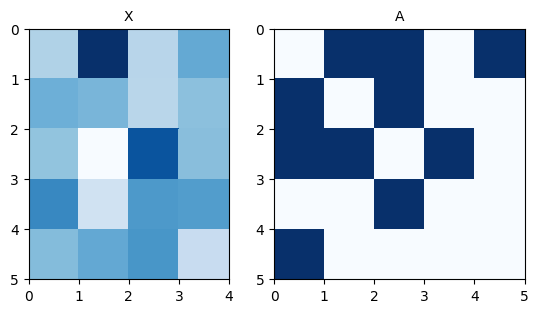

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# グラフ特徴の定義
# ここでは一括で乱数を用いて定義します．
# あとあとの図示で差がわかりやすいように+1しています
num_node = 5
in_channels = 4
X = np.random.randn(num_node, in_channels) + 1
print(X)

# エッジの定義
E = [[0, 1], [0, 2], [0, 4], [1, 2], [2, 3]]

# 向きを考慮しないので逆向きのエッジを定義
reversed_E = [[j, i] for [i, j] in E]

# エッジを足します
new_E = E + reversed_E

# エッジから隣接行列を作成する関数を定義します
def edge2mat(E, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in E:
        A[j, i] = 1
    return A

# 隣接行列の作成
A = edge2mat(new_E, num_node)  # ノードの数は5

# 結果の出力
print(f"エッジ: {new_E}")
print(f"入力サイズ: {X.shape}")
print(f"隣接行列サイズ: {A.shape}")

fig, ax = plt.subplots(1, 2, width_ratios=[4, 5])
ax[0].pcolor(X, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(A, cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('A', fontsize=10)
ax[1].invert_yaxis()

どうでしょうか？Fig.2と同じような出力が確認できましたね！<br>
エッジから隣接行列に変換する部分が少しややこしいくらいであとは特に難しい処理はしてません．<br>
<br>
この隣接行列は自身への接続が考慮されていないので，単位行列$\mathbf{I}\in\mathbb{R}^{V\times V}$を追加して自己ループを考慮します．<br>
自己ループを追加した隣接行列$\tilde{\mathbf{A}}=\mathbf{A+I}$はFig.3のような行列になります<br>
<img src="asset/graph-convolutional-network/self_loop.png" width="512"><br>
*Fig.3 自己ループを考慮した隣接行列*<br>
<br>
よって上記のソースコードは以下のように修正されます．

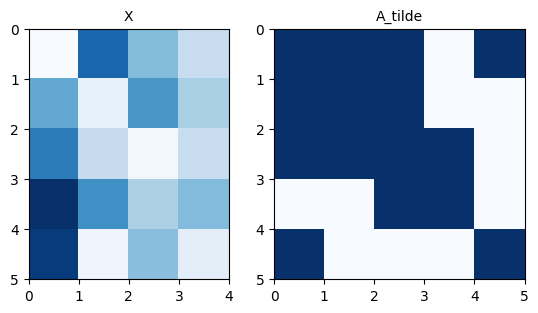

In [3]:
# エッジの定義
E = [[0, 1], [0, 2], [0, 4], [1, 2], [2, 3]]
reversed_E = [[j, i] for [i, j] in E]
new_E = E + reversed_E

# 自己ループ
I = [[i, i] for i in range(num_node)] 

# 隣接行列の作成
A_tilde = edge2mat(new_E + I, num_node)  # Iが追加

fig, ax = plt.subplots(1, 2, width_ratios=[4, 5])
ax[0].pcolor(X, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(A_tilde, cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('A_tilde', fontsize=10)
ax[1].invert_yaxis()

グラフ構造はなんとなく理解できてきましたか？<br>
ではようやくグラフ畳み込みを理解していきましょう！<br>

## 隣接行列を持ちいたノードの集約
ここでは隣接行列$\mathbf{A}$を用いてノード特徴$\mathbf{X}$を集約していきます．<br>
なんとここまでくればドット積するだけで集約はできます．<br>
<img src="asset/graph-convolutional-network/ax.png" width="512"><br>
Fig.4 ドット積<br>
<br>
Fig.4のオレンジで囲ってある部分を行列計算してみください．<br>
<br>
$$
[1,1,1,0,1]
\left[
\begin{array}{c}
v_1 \\
v_2 \\
v_3 \\
v_4 \\
v_5 \\
\end{array}
\right]
= v_1 + v_2 + v_3 + v_5 
$$
<br>
隣接行列のおかげで隣接ノードの特徴のみが足し合わされましたね！<br>
では実際この計算をpythonでやってみましょう

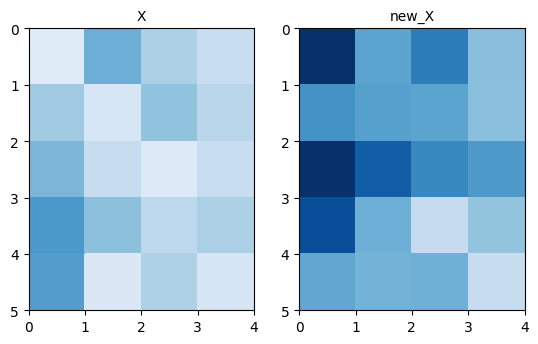

In [4]:
# 行列計算
new_X = A_tilde @ X 

# 結果の図示
fig, ax = plt.subplots(1, 2, width_ratios=[4, 4])
ax[0].pcolor(X, cmap=plt.cm.Blues, vmin=-1, vmax=5)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(new_X, cmap=plt.cm.Blues, vmin=-1, vmax=5)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('new_X', fontsize=10)
ax[1].invert_yaxis()


どうでしょう？<br>
なんかノードによって偏りが出ていますね．<br>
それもそのはずで，$v_1$なんかは4つのノードと接続されているのに対し，$v_5$は2つだけしか接続されていません．<br>
<br>
では，どうしたらいいでしょう？
<br>
一番簡単なのは，合計ではなく平均で集約してしまうことですね．<br>
グラフの分野では次数行列と呼ばれる接続ノードの数を表す行列$\tilde{\mathbf{D}}$を用います<br>
(~がついているのは$\tilde{\mathbf{A}}$と対応していることを示すためです）<br>
次数行列の各要素は$\tilde{d}_{ii}=\sum_{j=1}^{V}\tilde{a}_{ij}$と計算できます(Fig.5)．<br>
<img src="asset/graph-convolutional-network/d.png" width="512"><br>
*Fig.5 次数行列*<br>
<br>

次数行列を用いると平均による集約は$\tilde{\mathbf{D}}^{-1}\tilde{\mathbf{A}}\mathbf{X}$と計算ができます．<br>
実際にpythonで計算してみましょう.

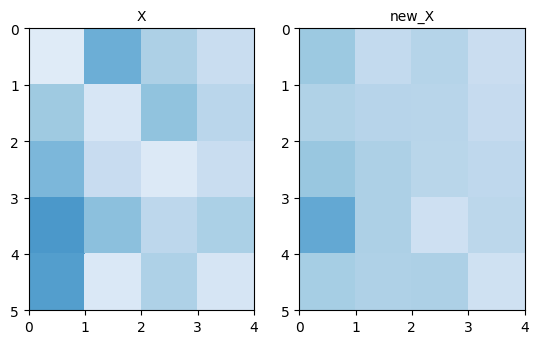

In [5]:
# 次数行列を計算する関数
# 行列のn乗の処理をあとあとするのはめんどくさいのでここで実装しておく
def get_D(A, pow=-1):
    d_ii = np.sum(A, 0)
    D = np.zeros_like(A)
    for i in range(len(A)):
        D[i, i] = d_ii[i]**(pow)
    return D

# 次数行列
D_tilde = get_D(A_tilde)

# 行列計算
new_X = D_tilde @ A_tilde @ X

# 結果の図示
fig, ax = plt.subplots(1, 2, width_ratios=[4, 4])
ax[0].pcolor(X, cmap=plt.cm.Blues, vmin=-1, vmax=5)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(new_X, cmap=plt.cm.Blues, vmin=-1, vmax=5)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('new_X', fontsize=10)
ax[1].invert_yaxis()

どうでしょうか？<br>
さっきよりも満遍なく集約できていますね．<br>
実際にGCNでは平均よりも$\tilde{\mathbf{D}}^{-\frac{1}{2}}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-\frac{1}{2}}\mathbf{X}$のような正規化が使われることが多いです．<br>
他にもこの辺りは研究されていて，中心ノードからの距離によって接続の強さを変えたり，エッジの向きごとに正規化したりなどがあります．<br>
ちなみに$\tilde{\mathbf{D}}^{-1}\tilde{\mathbf{A}}\mathbf{X}$と$\tilde{\mathbf{D}}^{-\frac{1}{2}}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-\frac{1}{2}}\mathbf{X}$の差は実装してみると早いですが，対称行列になっていますね<br>

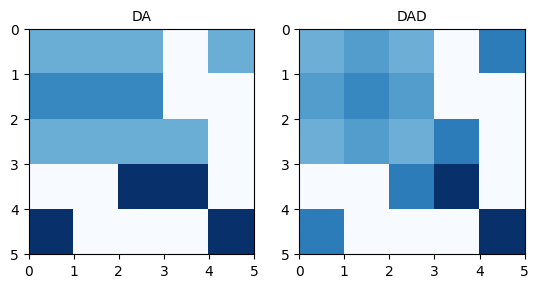

In [6]:
# DA
D_tilde = get_D(A_tilde, pow=-1)
DA = D_tilde @ A_tilde

# DAD
D_tilde = get_D(A_tilde, pow=-0.5)
DAD = D_tilde @ A_tilde @ D_tilde

# 結果の図示
fig, ax = plt.subplots(1, 2, width_ratios=[5, 5])
ax[0].pcolor(DA, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('DA', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(DAD, cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('DAD', fontsize=10)
ax[1].invert_yaxis()

さて，なんとなく集約の方法は理解できてきましたか？<br>
ただ，これではただ平均しているだけで学習できてませんね．<br>
ここから学習可能な重み導入していきます！<br>

## 畳み込み演算
画像のCNNを思い出してみてください．<br>
縦のエッジを捉えるカーネルや斜めのエッジを捉えるカーネルの重みを用いて加重平均することで情報を周囲のピクセルの情報を集約していましたよね（Fig.6）<br>
<img src="asset/graph-convolutional-network/cnn.png" width="512"><br>
*Fig.6 CNNの畳み込みのイメージ*<br>
<br>
しかし，グラフではノードによって隣接ノードの数が違うので，3x3カーネルのような固定の重みを使うことができません．<br>
そこでエッジの重みを学習することで代用します．<br>
隣接ノードの特徴$\mathbf{x}$が$\mathbf{W}$によって重み付けされて集約されます（Fig.7）．<br>
<img src="asset/graph-convolutional-network/gcn.png" width="512"><br>
*Fig.7 エッジの重み付け*<br>
<br>
数式では$\tilde{\mathbf{D}}^{-\frac{1}{2}}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-\frac{1}{2}}\mathbf{X}\mathbf{W}$のように表現できる．<bf>
ここで$\mathbf{W}\in\mathbb{R}^{c\times c_{out}}$となります．<br>
数式通り実装すると以下のようになります．

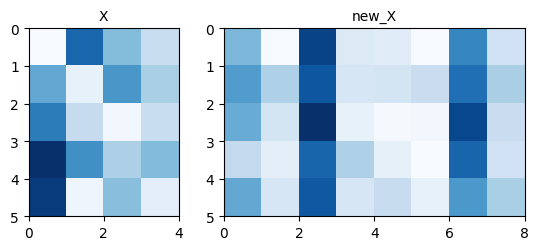

In [7]:
import torch
from torch import nn

# この実装からは適宜pytorchを用います
# 各行列をTensorに変換
X_tensor = torch.tensor(X, dtype=torch.float32)
A_tensor = torch.tensor(A_tilde, dtype=torch.float32)
D_tensor = torch.tensor(D_tilde, dtype=torch.float32)

# 重みを設定
# 出力channelsは8とする
out_channels = 8
W_tensor = nn.Parameter(torch.randn((in_channels, out_channels)))

# 行列計算
XW = X_tensor @ W_tensor
new_X_tensor = D_tensor @ A_tensor @ D_tensor @ XW
new_X = new_X_tensor.detach().numpy()

# 結果の図示
fig, ax = plt.subplots(1, 2, width_ratios=[4, 8])
ax[0].pcolor(X, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(new_X, cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('new_X', fontsize=10)
ax[1].invert_yaxis()

実際の学習では，このWの重みを学習することによって重要度の低いノードの重みは小さく，重要度の高いノードの重みは大きくなるように更新します．<br>
また，上記の実装をCNNらしく実装してみましょう．<br>
つまり$1\times V$の画像と考え，1x1のカーネルで畳み込みます．<br>
<img src="asset/graph-convolutional-network/gcn_like_cnn.png" width="512"><br>
*Fig.8 CNNに則したGCNのイメージ*<br>
<br>

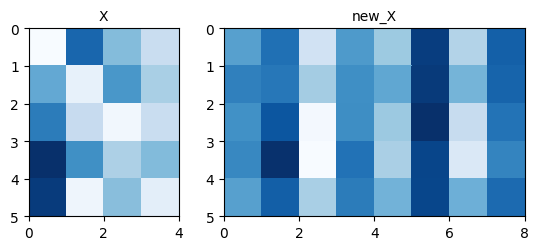

In [14]:
from einops import rearrange

X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = rearrange(X_tensor, "V C -> C 1 V")
A_tensor = torch.tensor(A_tilde, dtype=torch.float32)
D_tensor = torch.tensor(D_tilde, dtype=torch.float32)

# 重みをConvとして設定
conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

# 行列計算
XW = conv(X_tensor)
XW = rearrange(XW, "C 1 V -> V C")
new_X_tensor = D_tensor @ A_tensor @ D_tensor @ XW
# # einsumでも可能
# new_X_tensor = torch.einsum("cjv, iv -> cji", XW, D_tensor @ A_tensor @ D_tensor)
# new_X_tensor = rearrange(new_X_tensor, "C 1 V -> V C")
new_X = new_X_tensor.detach().numpy()

# 結果の図示
fig, ax = plt.subplots(1, 2, width_ratios=[4, 8])
ax[0].pcolor(X, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(new_X, cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('new_X', fontsize=10)
ax[1].invert_yaxis()

PyTorchの`nn.Conv2d`を用いても同様の実装ができました．<br>
軸を増やす処理が増えるので手間かもしれませんが，例えば時系列のグラフを扱う時などはCxTxVとして入力することで一気に計算ができたりして便利ですね．<br>
行動認識モデルであるST-GCNは`nn.Conv2d`で実装されています．

## PyTroch Layerを作ってみる

最後に`nn.Linear`などと組み合わせて使えるように自作レイヤーとして定義してみます

In [15]:
class GraphConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, input, adj):
        """
        Args:
            input (Tensor): graph feature
                            input.size() = (N, V, C)
            adj (Tensor): normalized adjacency matrix.
                          e.g. DAD or DA
                          input.size() = (V, V)
        Returns:
            Tensor: out.size() = (N, V, C_out)
        """
        input = rearrange(input, "N V C -> N C 1 V")
        XW = self.conv(input)
        DADXW = torch.einsum('NCTV,VW->NCTW', XW, adj)
        DADXW = rearrange(DADXW, "N C 1 V -> N V C")
        return DADXW

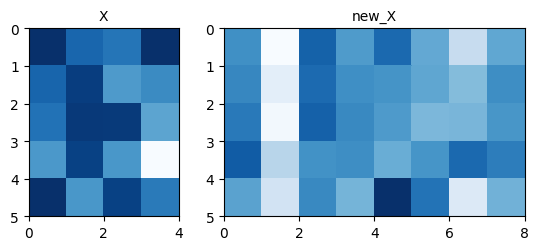

In [16]:
from torch.utils.data import TensorDataset, DataLoader

# フェイクデータ
X = np.random.randn(10, num_node, in_channels)
y = [0] * 5 + [1] * 5
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int64)
data = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(data, batch_size=4)

# DADの定義
A_tensor = torch.tensor(A_tilde, dtype=torch.float32)
D_tensor = torch.tensor(D_tilde, dtype=torch.float32)
DAD = D_tensor @ A_tensor @ D_tensor

# モデルの定義
model = GraphConv(in_channels, out_channels)

# バッチ処理
for input, label in loader:
    new_X_tensor = model(input, DAD)
    new_X = new_X_tensor.detach().numpy()

# 結果の図示
fig, ax = plt.subplots(1, 2, width_ratios=[4, 8])
ax[0].pcolor(X[0], cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('X', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(new_X[0], cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('new_X', fontsize=10)
ax[1].invert_yaxis()